# PLOT NRES RVs

Here we plot standard star RV measurements. These standard star do not exihibit significant RV variations. We assume we cannot measure astrophysical RV variations in these stars and, hence, any variation might be introduce by the instrument and data reduction process. We will investigate RV measurements using CERES. 

In [1]:
import os
from astropy.io import fits, ascii
import numpy as np
import math
# For interactive bokeh plotting
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook
from bokeh.layouts import gridplot
output_notebook()

# For matplotlib plotting, easier to make plots with error bars
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from scipy import optimize
import corner
import radvel
from radvel.plot import orbit_plots, mcmc_plots
import copy

# define directory and plot parameters

dir_ceres = 'data/'
plotheight = 700
plotwidth = 900

#Tooltips allow to hover over point and see details.

TOOLTIPS = [
	("WAVELENGTH","$x{0.2f}"),
	("FLUX", "$y{0.2f}")
]

TOOLTIPS1 = [
    ("DAY","@day"),
    ("(x,y)", "(@x{0.2f},@y0{0.2f})"),
    ("SNR","@snr{0.2f}"),
    ("FILE","@filen")
]

TOOLTIPS2 = [
    ("DAY","@day"),
    ("(x,y)", "(@x{0.2f},@y1{0.3f})"),
    ("SNR","@snr{0.2f}"),
    ("FILE","@filen")
]


Loading BokehJS ...

/home/mrabus/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


All RVs have been collected in a single csv file per star. The `csv` file has the following keys:

| Key         | Description                            | 
| ----------- | -----------                            |
| object      | Name of the object                     |
| BJD         | Baricentric Julian Date                |
| RV          | measured radial velocity               |
| RVerr       | formal error of RV measurement         |
| BS          | measured bi-sector span                |
| BSerr       | formal error of BS measurment          |
| SNR         | estimated signal-to-noise at ~5150 \AA |
| exptime     | CERES radial velocity measurement      |
| site        | NRES site                              |
| file        | original raw file name                 |
| day         | Observing time in UTC                  |


NRES is a robotic telescope, currently without exposure meter. Therefore, observed spectra does not always have a SNR high enough to be usuable. Maybe guiding did not work properly, atmospheric extinction was higher than usual and so on...

Sometimes there might be problems with the calibration images causing problems in the data reduction, we also mask measruements with unrealisticly high error bars. The formal error should generally be below 10 m/s, if it is higher then something has gone wrong in the wavelength calibration process.

## GJ2066

M2.0V star

measured GAIA RV: 61.460

In [2]:
# Load RV measurments as astropy table and mask low SNR measurements and create mask for each site
target_tab = ascii.read( os.path.join(dir_ceres,'GJ2066_RV.csv') )

masksnr = target_tab['SNR'] > 20 # everything above a SNR of 20 is good
target_tab = target_tab[masksnr]

maskerr = target_tab['RVerr'] < 0.1 # errors below 100 m/s are good, 
target_tab = target_tab[maskerr]


mask_lsc = target_tab['site'] == 'lsc'
mask_cpt = target_tab['site'] == 'cpt'
mask_elp = target_tab['site'] == 'elp'
mask_tlv = target_tab['site'] == 'tlv'


In [3]:
# Use Bokeh ColumnDataSource object for ploting.
source_lsc = ColumnDataSource( data=dict(
        x    = target_tab[mask_lsc]['BJD']-2450000.,
        y0   = target_tab[mask_lsc]['RV'],
        y1   = target_tab[mask_lsc]['BS'],
        day  = target_tab[mask_lsc]['day'],
        snr  = target_tab[mask_lsc]['SNR'],
        filen= target_tab[mask_lsc]['file'] ))

source_cpt = ColumnDataSource( data=dict(
        x     = target_tab[mask_cpt]['BJD']-2450000.,
        y0    = target_tab[mask_cpt]['RV'],
        y1    = target_tab[mask_cpt]['BS'],
        day   = target_tab[mask_cpt]['day'],
        snr   = target_tab[mask_cpt]['SNR'],
        filen = target_tab[mask_cpt]['file'] ))

source_elp = ColumnDataSource( data=dict(
        x     = target_tab[mask_elp]['BJD']-2450000.,
        y0    = target_tab[mask_elp]['RV'],
        y1    = target_tab[mask_elp]['BS'],
        day   = target_tab[mask_elp]['day'],
        snr   = target_tab[mask_elp]['SNR'],
        filen = target_tab[mask_elp]['file'] ))

source_tlv = ColumnDataSource( data=dict(
        x     = target_tab[mask_tlv]['BJD']-2450000.,
        y0    = target_tab[mask_tlv]['RV'],
        y1    = target_tab[mask_tlv]['BS'],
        day   = target_tab[mask_tlv]['day'],
        snr   = target_tab[mask_tlv]['SNR'],
        filen = target_tab[mask_tlv]['file'] ))




/home/mrabus/miniconda3/lib/python3.7/site-packages/bokeh/core/property/container.py:102: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(value, (collections.Container, collections.Sized, collections.Iterable))


In [4]:
bfig0 = figure( width=plotwidth, plot_height=plotheight, tooltips=TOOLTIPS1 )#,tools=select_tools)
bfig0.circle('x', 'y0', color="blue", hover_color="yellow", size=10, line_width=2, source=source_lsc, 
             legend='lsc   ({:.4f} km/s {:.4f} km/s)'.format( np.mean(target_tab[mask_lsc]['RV']),
                                                              np.std(target_tab[mask_lsc]['RV'])) )
bfig0.circle('x', 'y0', color="green", hover_color="yellow", size=10, line_width=2, source=source_cpt, line_alpha=0.5,
             legend='cpt   ({:.4f} km/s {:.4f} km/s)'.format( np.mean(target_tab[mask_cpt]['RV']),
                                                             np.std(target_tab[mask_cpt]['RV'])) )
bfig0.circle('x', 'y0', color="red", hover_color="yellow", size=10, line_width=2, source=source_elp, line_alpha=0.5,
             legend='elp   ({:.4f} km/s {:.4f} km/s)'.format( np.mean(target_tab[mask_elp]['RV']),
                                                             np.std(target_tab[mask_elp]['RV'])) )
bfig0.circle('x', 'y0', color="cyan", hover_color="yellow", size=10, line_width=2, source=source_tlv, line_alpha=0.5,
             legend='tlv   ({:.4f} km/s {:.4f} km/s)'.format( np.mean(target_tab[mask_tlv]['RV']),
                                                             np.std(target_tab[mask_tlv]['RV'])) )
bfig0.xaxis.axis_label = "BJD-2450000.0 [d]"
bfig0.yaxis.axis_label = "Radial Velocity [km/s]"


p = gridplot([[bfig0]])
show(p)

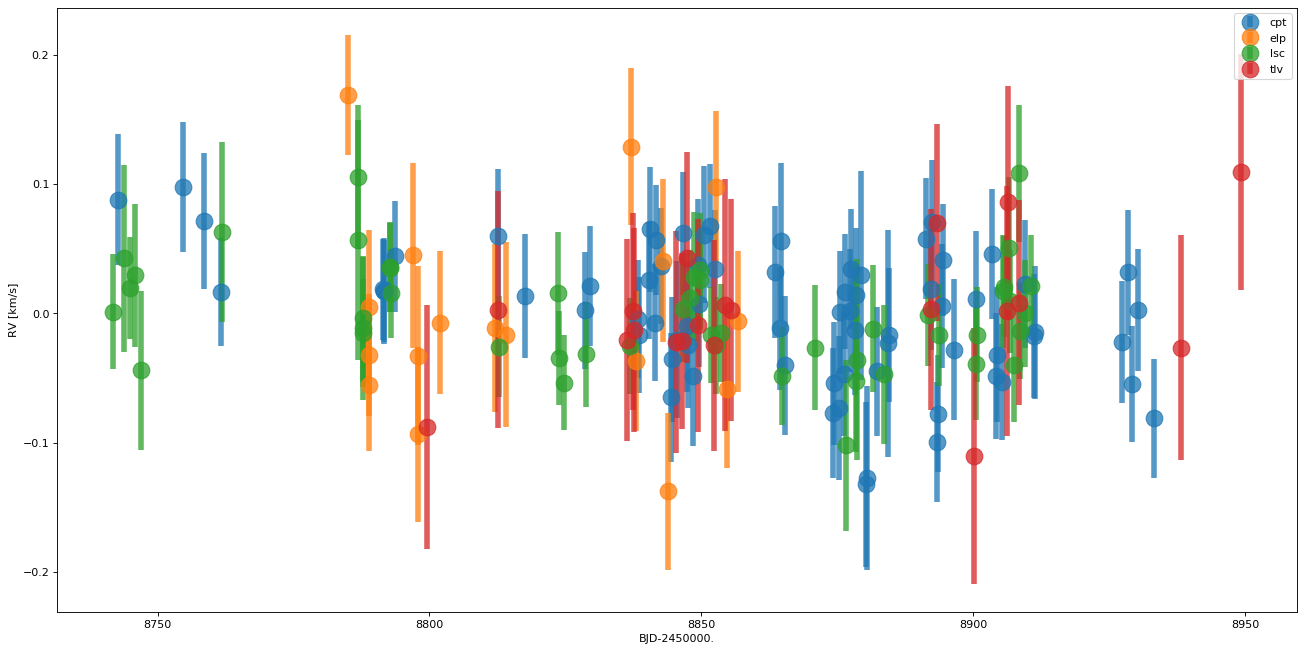

In [5]:
# Matplotlib plot with error bars
plt.figure(1,figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')

#Here we plot mean subtracted RVs:
plt.errorbar( target_tab[mask_cpt]['BJD']-2450000., target_tab[mask_cpt]['RV']-np.mean( target_tab[mask_cpt]['RV'] ), 
             yerr=target_tab[mask_cpt]['RVerr'], fmt='o', ms=15, lw=5, alpha=0.75, label='cpt' )

plt.errorbar( target_tab[mask_elp]['BJD']-2450000., target_tab[mask_elp]['RV']-np.mean( target_tab[mask_elp]['RV'] ), 
             yerr=target_tab[mask_elp]['RVerr'], fmt='o', ms=15, lw=5, alpha=0.75, label='elp' )

plt.errorbar( target_tab[mask_lsc]['BJD']-2450000., target_tab[mask_lsc]['RV']-np.mean( target_tab[mask_lsc]['RV'] ), 
             yerr=target_tab[mask_lsc]['RVerr'], fmt='o', ms=15, lw=5, alpha=0.75, label='lsc' )

plt.errorbar( target_tab[mask_tlv]['BJD']-2450000., target_tab[mask_tlv]['RV']-np.mean( target_tab[mask_tlv]['RV'] ), 
             yerr=target_tab[mask_tlv]['RVerr'], fmt='o', ms=15, lw=5, alpha=0.75, label='tlv' )
plt.xlabel('BJD-2450000.' )
plt.ylabel('RV [km/s]')
plt.legend()


## GJ699 (Barnard's star)

M4V star

measured RV (Nidever et al. 2002): -110.506

So far, this star has only been observed by three sites, namely cpt, lsc and tlv.

In [6]:
# Load RV measurments as astropy table and mask low SNR measurements and create mask for each site
target_tab = ascii.read( os.path.join(dir_ceres,'GJ699_RV.csv') )

masksnr = target_tab['SNR'] > 20 # everything above a SNR of 20 is good
target_tab = target_tab[masksnr]

maskerr = target_tab['RVerr'] < 0.1 # errors below 100 m/s are good, 
target_tab = target_tab[maskerr]

mask_cpt = target_tab['site'] == 'cpt'
mask_lsc = target_tab['site'] == 'lsc'
mask_tlv = target_tab['site'] == 'tlv'

In [7]:
source_lsc = ColumnDataSource( data=dict(
        x     = target_tab[mask_lsc]['BJD']-2450000.,
        y0    = target_tab[mask_lsc]['RV'],
        y1    = target_tab[mask_lsc]['BS'],
        day   = target_tab[mask_lsc]['day'],
        snr   = target_tab[mask_lsc]['SNR'],
        filen = target_tab[mask_lsc]['file'] ))

source_cpt = ColumnDataSource( data=dict(
        x     = target_tab[mask_cpt]['BJD']-2450000.,
        y0    = target_tab[mask_cpt]['RV'],
        y1    = target_tab[mask_cpt]['BS'],
        day   = target_tab[mask_cpt]['day'],
        snr   = target_tab[mask_cpt]['SNR'],
        filen = target_tab[mask_cpt]['file'] ))

source_tlv = ColumnDataSource( data=dict(
        x     = target_tab[mask_tlv]['BJD']-2450000.,
        y0    = target_tab[mask_tlv]['RV'],
        y1    = target_tab[mask_tlv]['BS'],
        day   = target_tab[mask_tlv]['day'],
        snr   = target_tab[mask_tlv]['SNR'],
        filen = target_tab[mask_tlv]['file'] ))


In [8]:
bfig0 = figure( width=plotwidth, plot_height=plotheight, tooltips=TOOLTIPS1 )#,tools=select_tools)
bfig0.circle('x', 'y0', color="blue", hover_color="yellow", size=10, line_width=2, source=source_lsc,
             legend='lsc   ({:.4f} km/s {:.4f} km/s)'.format( np.mean(target_tab[mask_lsc]['RV']),
                                                             np.std(target_tab[mask_lsc]['RV'])) )
bfig0.circle('x', 'y0', color="green", hover_color="yellow", size=10, line_width=2, source=source_cpt, line_alpha=0.5,
             legend='cpt   ({:.4f} km/s {:.4f} km/s)'.format( np.mean(target_tab[mask_cpt]['RV']),
                                                             np.std(target_tab[mask_cpt]['RV'])) )
bfig0.circle('x', 'y0', color="red", hover_color="yellow", size=10, line_width=2, source=source_tlv, line_alpha=0.5,
             legend='tlv   ({:.4f} km/s {:.4f} km/s)'.format( np.mean(target_tab[mask_tlv]['RV']),
                                                             np.std(target_tab[mask_tlv]['RV'])) )
bfig0.xaxis.axis_label = "BJD-2450000.0 [d]"
bfig0.yaxis.axis_label = "Radial Velocity [km/s]"

p = gridplot([[bfig0]])
show(p)

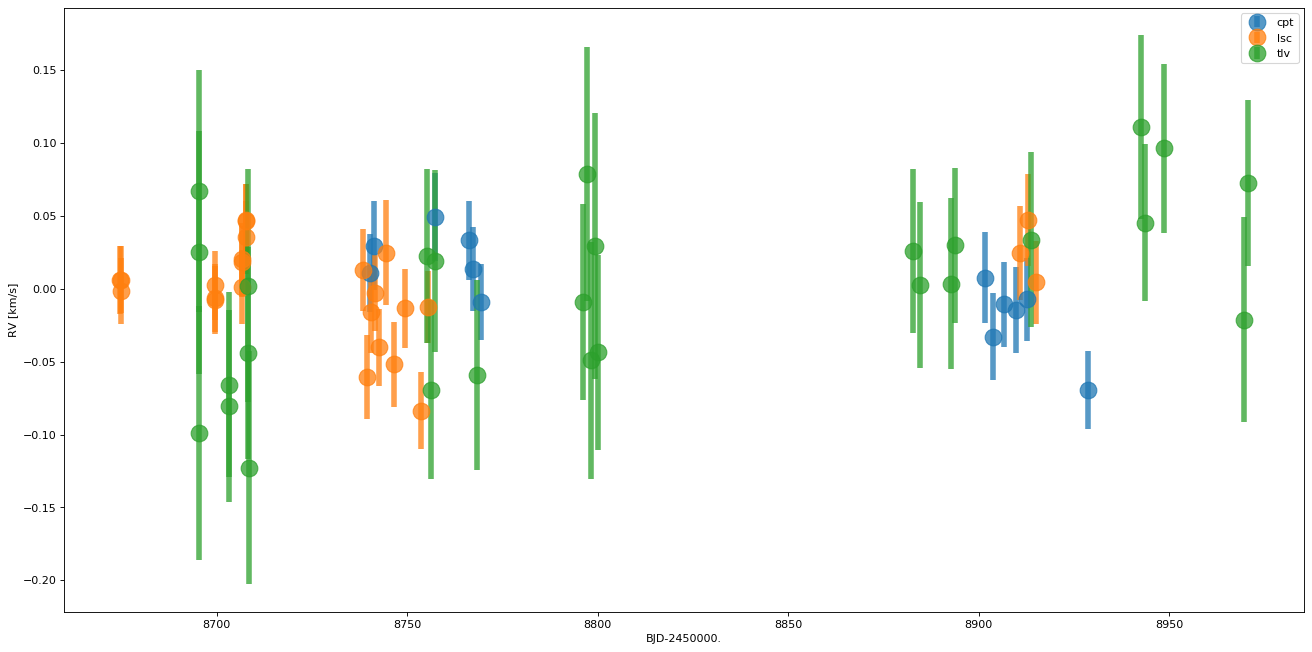

In [9]:
#Matplotlib plot with error bars
plt.figure(2,figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')

#Here we plot mean subtracted RVs:
plt.errorbar( target_tab[mask_cpt]['BJD']-2450000., target_tab[mask_cpt]['RV']-np.mean( target_tab[mask_cpt]['RV'] ), 
             yerr=target_tab[mask_cpt]['RVerr'], fmt='o', ms=15, lw=5, alpha=0.75, label='cpt' )

plt.errorbar( target_tab[mask_lsc]['BJD']-2450000., target_tab[mask_lsc]['RV']-np.mean( target_tab[mask_lsc]['RV'] ), 
             yerr=target_tab[mask_lsc]['RVerr'], fmt='o', ms=15, lw=5, alpha=0.75, label='lsc' )

plt.errorbar( target_tab[mask_tlv]['BJD']-2450000., target_tab[mask_tlv]['RV']-np.mean( target_tab[mask_tlv]['RV'] ), 
             yerr=target_tab[mask_tlv]['RVerr'], fmt='o', ms=15, lw=5, alpha=0.75, label='tlv' )
plt.xlabel('BJD-2450000.' )
plt.ylabel('RV [km/s]')
plt.legend()

## Fit orbital parameters for 51Peg
Do we have enough precision to detect Hot Jupiter planets through RV measurements. We will use RV measurement of a known exoplanet to fit the orbit using `radvel` (git@github.com:California-Planet-Search/radvel.git)

In [10]:
data = pd.read_csv(os.path.join(dir_ceres,'RV_51Peg_all.csv'), sep=',')

rv_lsc = data.query("tel == 'lsc'")
rv_cpt = data.query("tel == 'cpt'")
rv_elodie = data.query("tel == 'elodie'")

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = np.linspace(t_start,t_stop,10000)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

starname = '51Peg'
nplanets = 1    # number of planets in the system
ntels = len(instnames)       # number of instruments with unique velocity zero-points
fitting_basis = 'per tc secosw sesinw logk'    # Fitting basis, see radvel.basis.BASIS_NAMES for available basis names

In [11]:
time_base = 2456326          # abscissa for slope and curvature terms (should be near mid-point of time baseline)
nplanets=1
anybasis_params = radvel.Parameters(nplanets,basis='per tc e w k')    # initialize Parameters object

anybasis_params['per1'] = radvel.Parameter(value=4.23077)
anybasis_params['tc1'] = radvel.Parameter(value=2456326.9314)
anybasis_params['e1'] = radvel.Parameter(value=0.0)          # eccentricity of 1st planet
anybasis_params['w1'] = radvel.Parameter(value=math.radians(58.1))
anybasis_params['k1'] = radvel.Parameter(value=55.0)
anybasis_params['dvdt'] = radvel.Parameter(value=0.,vary=False)
anybasis_params['curv'] = radvel.Parameter(value=0.,vary=False)

anybasis_params['gamma_lsc'] = radvel.Parameter(value=-33300)       # velocity zero-point for lsc
anybasis_params['gamma_cpt'] = radvel.Parameter(value=-33200)       # "                   "   cpt
anybasis_params['gamma_elodie'] = radvel.Parameter(value=-33200)    # "                   "   elodie

anybasis_params['jit_lsc'] = radvel.Parameter(value=10.0)       # jitter for lsc
anybasis_params['jit_cpt'] = radvel.Parameter(value=10.0)       # "      "   cpt
anybasis_params['jit_elodie'] = radvel.Parameter(value=10.0)    # "      "   elodie

params = anybasis_params.basis.to_any_basis(anybasis_params,fitting_basis)

mod = radvel.RVModel(params, time_base=time_base)


In [12]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like


# Build lsc likelihood
like_lsc = initialize_likelihood(rv_lsc,'_lsc')
like_lsc.params['gamma_lsc'] = radvel.Parameter(value=-33300)
like_lsc.params['jit_lsc'] = radvel.Parameter(value=20)

# Build lsc likelihood
like_cpt = initialize_likelihood(rv_cpt,'_cpt')
like_cpt.params['gamma_cpt'] = radvel.Parameter(value=-33200)
like_cpt.params['jit_cpt'] = radvel.Parameter(value=20)

# Build lsc likelihood
like_elodie = initialize_likelihood(rv_elodie,'_elodie')
like_elodie.params['gamma_elodie'] = radvel.Parameter(value=-33200)
like_elodie.params['jit_elodie'] = radvel.Parameter(value=20)


# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood([like_lsc,like_cpt,like_elodie])

# Set initial values for jitter
like.params['jit_lsc'] = radvel.Parameter(value=20)
like.params['jit_cpt'] = radvel.Parameter(value=20)
like.params['jit_elodie'] = radvel.Parameter(value=20)


like.params['dvdt'].vary = False
like.params['curv'].vary = False
#like.params['jit_lsc'].vary = False
#like.params['jit_cpt'].vary = False
#like.params['jit_elodie'].vary = False




In [13]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 1 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -1470.780517
Final loglikelihood = -799.129350
parameter                     value      vary
per1                         4.2308       True
tc1                         6326.93       True
dvdt                              0      False
curv                              0      False
gamma_lsc                  -33389.3       True
gamma_cpt                  -33198.9       True
gamma_elodie               -33251.8       True
jit_lsc                      16.702       True
jit_cpt                     10.2677       True
jit_elodie                  9.23572       True
secosw1                   0.0479036       True
sesinw1                    -0.15943       True
logk1                       4.03221       True

Priors
------
e1 constrained to be < 0.99



(<Figure size 1440x555.429 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7faa20bb1f90>])

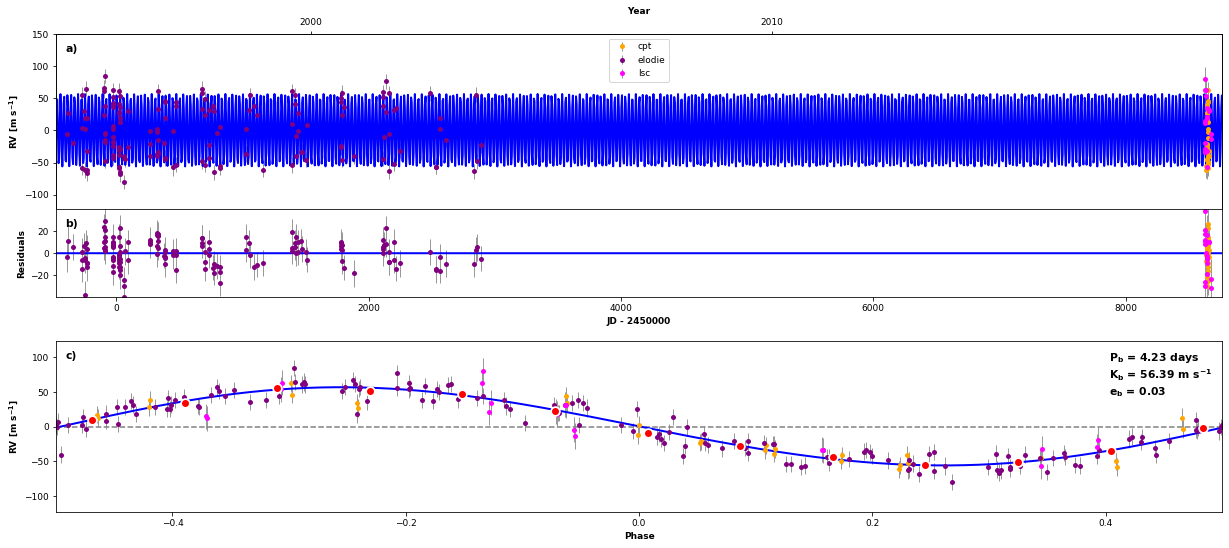

In [14]:
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.figwidth = 20
RVPlot.plot_multipanel()

In [15]:
data = pd.read_csv(os.path.join(dir_ceres,'RV_51Peg_lco.csv'), sep=',')

rv_lsc = data.query("tel == 'lsc'")
rv_cpt = data.query("tel == 'cpt'")

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = np.linspace(t_start,t_stop,10000)

telgrps = data.groupby('tel').groups
instnames = telgrps.keys()

starname = '51Peg'
nplanets = 1    # number of planets in the system
ntels = len(instnames)       # number of instruments with unique velocity zero-points
fitting_basis = 'per tc secosw sesinw logk'    # Fitting basis, see radvel.basis.BASIS_NAMES for available basis names

In [16]:
time_base = 2456326          # abscissa for slope and curvature terms (should be near mid-point of time baseline)
nplanets=1
anybasis_params = radvel.Parameters(nplanets,basis='per tc e w k')    # initialize Parameters object

anybasis_params['per1'] = radvel.Parameter(value=4.23077)
anybasis_params['tc1'] = radvel.Parameter(value=2456326.9314)
anybasis_params['e1'] = radvel.Parameter(value=0.0, vary=False)          # eccentricity of 1st planet
anybasis_params['secosw1'] = radvel.Parameter(value=0.0, vary=False)          
anybasis_params['sesinw1'] = radvel.Parameter(value=0.0, vary=False)          
anybasis_params['w1'] = radvel.Parameter(value=math.radians(58.1))
anybasis_params['k1'] = radvel.Parameter(value=55.0)
anybasis_params['dvdt'] = radvel.Parameter(value=0.,vary=False)
anybasis_params['curv'] = radvel.Parameter(value=0.,vary=False)

anybasis_params['gamma_lsc'] = radvel.Parameter(value=-33300)       # velocity zero-point for lsc
anybasis_params['gamma_cpt'] = radvel.Parameter(value=-33200)       # "                   "   cpt

anybasis_params['jit_lsc'] = radvel.Parameter(value=10.0)       # jitter for lsc
anybasis_params['jit_cpt'] = radvel.Parameter(value=10.0)       # "      "   cpt

params = anybasis_params.basis.to_any_basis(anybasis_params,fitting_basis)

mod = radvel.RVModel(params, time_base=time_base)


In [17]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.time, rv.mnvel, rv.errvel,suffix=suffix)
    return like


# Build lsc likelihood
like_lsc = initialize_likelihood(rv_lsc,'_lsc')
like_lsc.params['gamma_lsc'] = radvel.Parameter(value=-33300)
like_lsc.params['jit_lsc'] = radvel.Parameter(value=20)

# Build lsc likelihood
like_cpt = initialize_likelihood(rv_cpt,'_cpt')
like_cpt.params['gamma_cpt'] = radvel.Parameter(value=-33200)
like_cpt.params['jit_cpt'] = radvel.Parameter(value=20)


# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood([like_lsc,like_cpt])

# Set initial values for jitter
like.params['jit_lsc'] = radvel.Parameter(value=20)
like.params['jit_cpt'] = radvel.Parameter(value=20)

like.params['dvdt'].vary = False
like.params['curv'].vary = False
like.params['secosw1'].vary = False
like.params['sesinw1'].vary = False

In [18]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 1 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )

print("Initial loglikelihood = %f" % post0.logprob())
print("Final loglikelihood = %f" % post.logprob())
print(post)

Initial loglikelihood = -386.578245
Final loglikelihood = -203.705885
parameter                     value      vary
per1                        4.17751       True
tc1                         6326.93       True
secosw1                           0      False
sesinw1                           0      False
dvdt                              0      False
curv                              0      False
gamma_lsc                  -33385.2       True
gamma_cpt                  -33199.4       True
jit_lsc                     12.0723       True
jit_cpt                     12.4252       True
logk1                       3.95576       True

Priors
------
e1 constrained to be < 0.99



/home/mrabus/miniconda3/lib/python3.7/site-packages/radvel/utils.py:296: RuntimeWarning: invalid value encountered in true_divide
  bindat = sy / n
/home/mrabus/miniconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 0 missing from current font.
  font.set_text(s, 0.0, flags=flags)


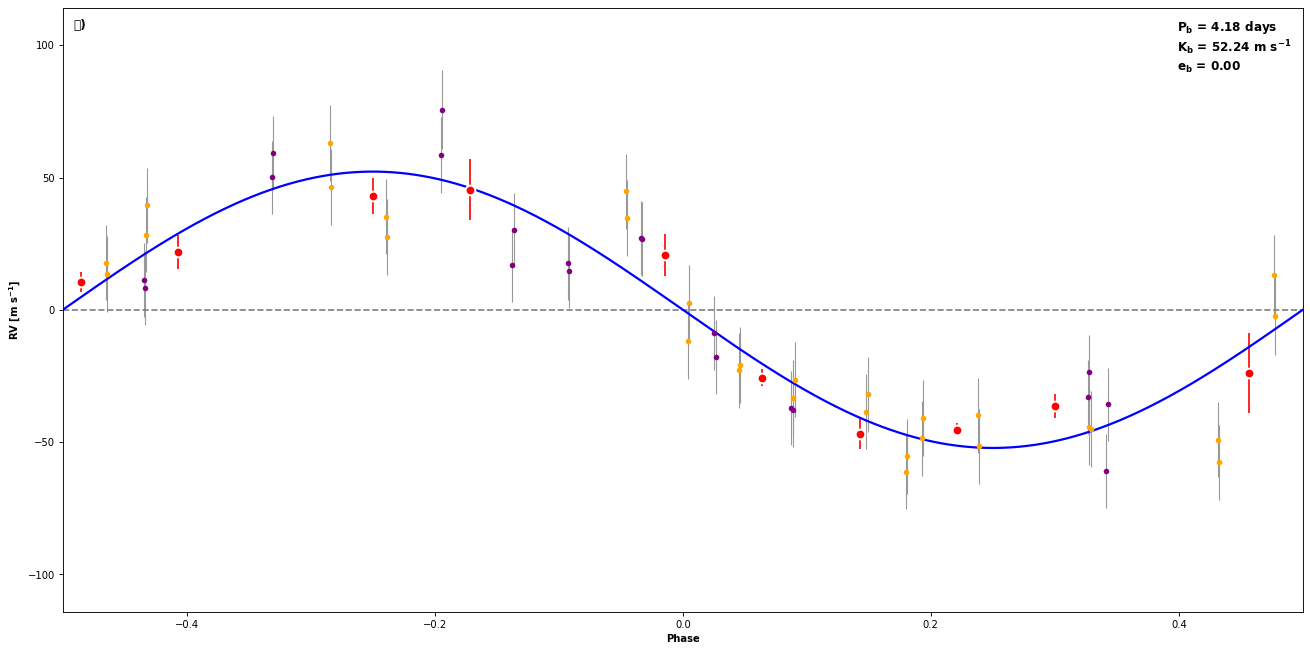

In [19]:
plt.figure(1,figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_phasefold(0,1)